In [13]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf


filename = 'backgroundCandidate.txt.zip'


In [8]:
f = open('test.txt')
f.read()
# vocabulary = tf.compat.as_str(f).split()
print(f)
# print('Data size', len(f))


FileNotFoundError: [Errno 2] No such file or directory: 'test.txt'

In [14]:
# Read the data into a list of strings.
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words."""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

vocabulary = read_data(filename)
print('Data size', len(vocabulary))

Data size 113


In [15]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 80


def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    word = word.strip(',')
    word = word.strip('.')
    word = word.strip('?')
    word = word.strip('!')
    word = word.strip('"')
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  print(len(reversed_dictionary))
  return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                            vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:50])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

80
Most common words (+UNK) [['UNK', 5], ('and', 6), ('to', 6), ('the', 5), ('a', 4), ('of', 4), ('I', 3), ('with', 2), ('set', 2), ('in', 2), ('have', 2), ('design', 2), ('from', 2), ('physical', 2), ('"I’m', 1), ('multidisciplinary', 1), ('designer,', 1), ('artist', 1), ('educator', 1), ('diverse', 1), ('toolkits,', 1), ('skills', 1), ('frameworks', 1), ('contribute', 1), ('IDEO', 1), ('CoLab', 1), ('Makeathon.', 1), ('Through', 1), ('my', 1), ('work', 1), ('designing', 1), ('interactive', 1), ('experiences,', 1), ('objects', 1), ('installations,', 1), ('cultivated', 1), ('toolkit', 1), ('methodologies', 1), ('that', 1), ('allow', 1), ('me', 1), ('ask', 1), ('right', 1), ('questions,', 1), ('identify', 1), ('solutions', 1), ('build', 1), ('different', 1), ('kinds', 1), ('prototypes.', 1)]
Sample data [14, 4, 15, 16, 17, 1, 18, 7, 4, 19] ['"I’m', 'a', 'multidisciplinary', 'designer,', 'artist', 'and', 'educator', 'with', 'a', 'diverse']


In [16]:

# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [skip_window]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])


4 a -> 14 "I’m
4 a -> 15 multidisciplinary
15 multidisciplinary -> 16 designer,
15 multidisciplinary -> 4 a
16 designer, -> 17 artist
16 designer, -> 15 multidisciplinary
17 artist -> 1 and
17 artist -> 16 designer,


In [17]:

# Step 4: Build and train a skip-gram model.

batch_size = 80
embedding_size = 80  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 80  # Only pick dev samples in the head of the distribution. CHANGED FROM 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Add variable initializer.
  init = tf.global_variables_initializer()


In [18]:

# Step 5: Begin training.
num_steps = 10001 # was 100001

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()


Initialized
Average loss at step  0 :  57.004863739
Nearest to solutions: video,, a, kinds, Makeathon., from, to, of, prototyping,,
Nearest to in: cardboard, from, co-design, processes, design, artist, to, diverse,
Nearest to of: (including, my, solutions, identify, technical, experiences,, video,, (fabrication,,
Nearest to "I’m: design, ask, me, frameworks, with, (graphic, right, IDEO,
Nearest to from: video,, in, Makeathon., prototyping,, solutions, have, I, Through,
Nearest to CoLab: interactive, build, Makeathon., circuits,, installations,, UNK, projection), interviews,
Nearest to allow: UNK, visual, everything, (including, projection), workshops),, processes, Makeathon.,
Nearest to toolkits,: (graphic, systems, circuits,, multidisciplinary, thinking., co-design, interactive, interviews,
Nearest to DIY: contribute, circuits,, UNK, build, human, (including, ask, in,
Nearest to centered: have, everything, me, systems, Makeathon., cardboard, am, prototypes.,
Nearest to IDEO: (includin

['UNK', 'and', 'to', 'the', 'a', 'of', 'I', 'with', 'set', 'in', 'have', 'design', 'from', 'physical', '"I’m', 'multidisciplinary', 'designer,', 'artist', 'educator', 'diverse', 'toolkits,', 'skills', 'frameworks', 'contribute', 'IDEO', 'CoLab', 'Makeathon.', 'Through', 'my', 'work', 'designing', 'interactive', 'experiences,', 'objects', 'installations,', 'cultivated', 'toolkit', 'methodologies', 'that', 'allow', 'me', 'ask', 'right', 'questions,', 'identify', 'solutions', 'build', 'different', 'kinds', 'prototypes.', 'am', 'experienced', 'research,', 'human', 'centered', 'co-design', 'processes', '(including', 'community', 'interviews', 'workshops),', 'rapid', 'prototyping', 'everything', 'cardboard', 'circuits,', 'systems', 'thinking.', 'varied', 'skills,', 'visual', '(graphic', 'design,', 'video,', 'projection)', '(fabrication,', 'prototyping,', 'DIY', 'hardware)', 'technical']


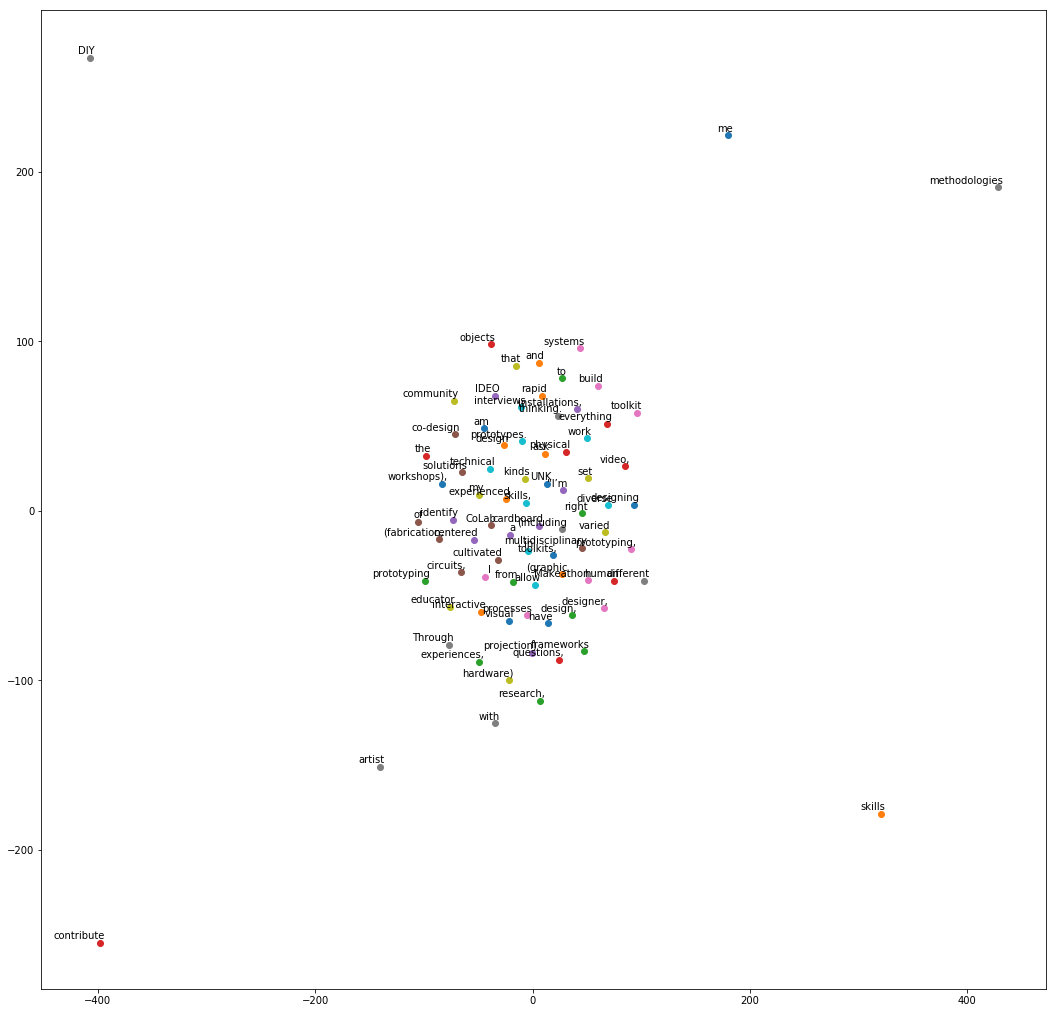

In [24]:
# # Step 6: Visualize the embeddings.

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  # import matplotlib
  # matplotlib.use('TkAgg')
  import matplotlib.pyplot as plt
  %matplotlib inline

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
  plot_only = 80
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  print(labels)
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')